In [9]:
import pandas as pd
import numpy as np

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header = None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 
                   'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 
                   'Proanthocyanins', 'Color intensity', 'Hue', 
                   'OD280/OD315 of diluted wines', 'Proline'
]
print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [25]:
from sklearn.cross_validation import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [23]:
len(df_wine.index)

RangeIndex(start=0, stop=178, step=1)

In [29]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators= 10000, 
                                random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)

In [46]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for idx, f in enumerate(indices):
    print("%2d) %-*s %f" % (idx + 1, 30, feat_labels[f], 
                           importances[f]))

 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948
 4) OD280/OD315 of diluted wines   0.131987
 5) Alcohol                        0.106589
 6) Hue                            0.078243
 7) Total phenols                  0.060718
 8) Alcalinity of ash              0.032033
 9) Malic acid                     0.025400
10) Proanthocyanins                0.022351
11) Magnesium                      0.022078
12) Nonflavanoid phenols           0.014645
13) Ash                            0.013916


In [82]:
indices

array([ 9, 12,  6, 11,  0, 10,  5,  3,  1,  8,  4,  7,  2])

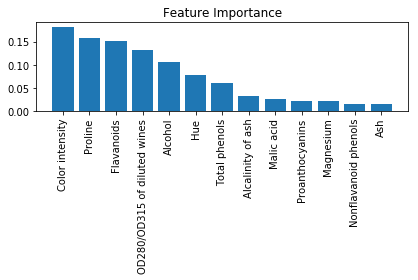

In [58]:
import matplotlib.pyplot as plt
plt.title('Feature Importance')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feat_labels[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

In [70]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score


class SBS():

  def __init__(self, estimator, k_features,
               scoring=accuracy_score,
               test_size=0.25, random_state=1):
    self.scoring = scoring
    self.estimator = clone(estimator)
    self.k_features = k_features
    self.test_size = test_size
    self.random_state = random_state

  def fit(self, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size,
                                                        random_state=self.random_state)
    dim = X_train.shape[1]
    self.indices_ = tuple(range(dim))
    self.subsets_ = [self.indices_]
    score = self._calc_score(X_train, y_train,
                             X_test, y_test, self.indices_)
    self.scores_ = [score]
    while dim > self.k_features:
      scores = []
      subsets = []
      for p in combinations(self.indices_, r=dim - 1):
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test, p)
        scores.append(score)
        subsets.append(p)

      best = np.argmax(scores)
      self.indices_ = subsets[best]
      self.subsets_.append(self.indices_)
      dim -= 1

      self.scores_.append(scores[best])
    self.k_score_ = self.scores_[-1]

    return self

  def transform(self, X):
    return X[:, self.indices_]

  def _calc_score(self, X_train, y_train,
                  X_test, y_test, indices):
    self.estimator.fit(X_train[:, indices], y_train)
    y_pred = self.estimator.predict(X_test[:, indices])
    score = self.scoring(y_test, y_pred)
    return score


In [71]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [72]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

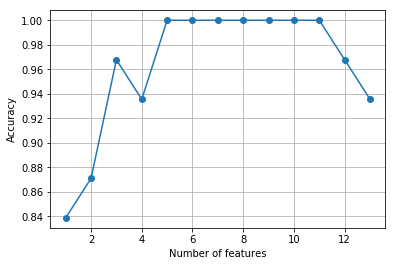

In [88]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
#plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [84]:
# use 8 because it's index of k5 from the end(decreasing features order)
#k5 = list(sbs.subsets_[8])
k5 = [9, 12,  6, 11,  0]

print(df_wine.columns[1:][k5])


Index(['Color intensity', 'Proline', 'Flavanoids',
       'OD280/OD315 of diluted wines', 'Alcohol'],
      dtype='object')
